# Testing
### Aufenthaltsdauer, nach Alter, Geschlecht, Herkunft, Stadtkreis, seit 1993
Datum: 11.01.2022

Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy/blob/main/plausis/plausi_bev_jahresupdates/od3582_bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_OD3582.ipynb)



**Importiere die notwendigen Packages**

In [8]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [9]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 
import requests

In [10]:
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [11]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_aufenthaltsdauer_bestand_alter_geschlecht_herkunft_stadtkreis_od5241

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/bev_aufenthaltsdauer_bestand_alter_geschlecht_herkunft_stadtkreis_od5241

In [13]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [14]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bev_aufenthaltsdauer_bestand_alter_geschlecht_herkunft_stadtkreis_od5241/download/BEV524OD5241.csv"
else:
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bev_aufenthaltsdauer_bestand_alter_geschlecht_herkunft_stadtkreis_od5241/BEV524OD5241.csv"

print(fp)

https://data.stadt-zuerich.ch/dataset/bev_aufenthaltsdauer_bestand_alter_geschlecht_herkunft_stadtkreis_od5241/download/BEV524OD5241.csv


In [15]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [16]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [17]:
data2betested.head(3)

,StichtagDatJahr,AlterV20Kurz,AlterV20Sort,SexCd,SexKurz,HerkunftCd,HerkunftLang,KreisCd,KreisLang,AufDauerP25,AufDauerMedian,AufDauerP75,AufDauerMittel
0,2020,0-19,1,1,M,1,Schweizer/in,1,Kreis 1,4,9,13,9
1,2020,0-19,1,1,M,1,Schweizer/in,2,Kreis 2,4,8,13,8
2,2020,0-19,1,1,M,1,Schweizer/in,3,Kreis 3,4,9,13,9


In [18]:
data2betested.dtypes

StichtagDatJahr      int64
AlterV20Kurz        object
AlterV20Sort         int64
SexCd                int64
SexKurz             object
HerkunftCd           int64
HerkunftLang        object
KreisCd              int64
KreisLang           object
AufDauerP25        float64
AufDauerMedian     float64
AufDauerP75        float64
AufDauerMittel     float64
dtype: object

In [19]:
data2betested.shape

(265, 13)

Beschreibe einzelne Attribute

In [20]:
data2betested.describe()

,StichtagDatJahr,AlterV20Sort,SexCd,HerkunftCd,KreisCd,AufDauerP25,AufDauerMedian,AufDauerP75,AufDauerMittel
count,265,265,265,265,265,265,265,265,265
mean,2020,3,2,1,7,16,26,34,26
std,0,2,1,1,3,17,22,24,20
min,2020,1,1,1,1,0,1,3,3
25%,2020,2,1,1,3,3,8,13,9
50%,2020,3,2,1,7,10,19,28,21
75%,2020,5,2,2,10,25,40,56,39
max,2020,6,2,2,12,101,101,104,101


Wie viele Nullwerte gibt es im Datensatz?

In [21]:
data2betested.isnull().sum()

StichtagDatJahr    0
AlterV20Kurz       0
AlterV20Sort       0
SexCd              0
SexKurz            0
HerkunftCd         0
HerkunftLang       0
KreisCd            0
KreisLang          0
AufDauerP25        0
AufDauerMedian     0
AufDauerP75        0
AufDauerMittel     0
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [22]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,StichtagDatJahr,AlterV20Kurz,AlterV20Sort,SexCd,SexKurz,HerkunftCd,HerkunftLang,KreisCd,KreisLang,AufDauerP25,AufDauerMedian,AufDauerP75,AufDauerMittel
0,2020-01-01,0-19,1,1,M,1,Schweizer/in,1,Kreis 1,4,9,13,9
1,2020-01-01,0-19,1,1,M,1,Schweizer/in,2,Kreis 2,4,8,13,8
2,2020-01-01,0-19,1,1,M,1,Schweizer/in,3,Kreis 3,4,9,13,9
3,2020-01-01,0-19,1,1,M,1,Schweizer/in,4,Kreis 4,3,7,13,8
4,2020-01-01,0-19,1,1,M,1,Schweizer/in,5,Kreis 5,3,7,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,3,Kreis 3,9,39,68,39
261,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,4,Kreis 4,40,40,40,40
262,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,6,Kreis 6,39,39,39,39
263,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,8,Kreis 8,20,20,20,20


Bereite die Daten für die Grafik unten vor

In [23]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

1

In [24]:
for key, group in Jahre:
    print(key, len(group))

2020-01-01 00:00:00 265


In [25]:
myJahr = "2020-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr

,StichtagDatJahr,AlterV20Kurz,AlterV20Sort,SexCd,SexKurz,HerkunftCd,HerkunftLang,KreisCd,KreisLang,AufDauerP25,AufDauerMedian,AufDauerP75,AufDauerMittel
0,2020-01-01,0-19,1,1,M,1,Schweizer/in,1,Kreis 1,4,9,13,9
1,2020-01-01,0-19,1,1,M,1,Schweizer/in,2,Kreis 2,4,8,13,8
2,2020-01-01,0-19,1,1,M,1,Schweizer/in,3,Kreis 3,4,9,13,9
3,2020-01-01,0-19,1,1,M,1,Schweizer/in,4,Kreis 4,3,7,13,8
4,2020-01-01,0-19,1,1,M,1,Schweizer/in,5,Kreis 5,3,7,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,3,Kreis 3,9,39,68,39
261,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,4,Kreis 4,40,40,40,40
262,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,6,Kreis 6,39,39,39,39
263,2020-01-01,100 u. älter,6,2,W,2,Ausländer/in,8,Kreis 8,20,20,20,20


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [26]:
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    
test = data2betested.groupby(
   ['StichtagDatJahr', 'AlterV20Sort', 'AlterV20Kurz']
).agg(
    {
         'AufDauerMittel':(sum),    # Sum duration per group
         'AufDauerP25': "count",  # get the count of networks
         'AufDauerP75': 'count'  # get the first date per group
    }
)
test
    

AufDauerMittel  AufDauerP25  AufDauerP75
StichtagDatJahr AlterV20Sort AlterV20Kurz                                          
2020-01-01      1            0-19                     328           48           48
                2            20-39                    420           48           48
                3            40-59                    792           48           48
                4            60-79                   1490           48           48
                5            80-99                   2316           48           48
                6            100 u. älter            1452           25           25

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [27]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [31]:
mySelection = data2betested[(aktuellesJahr.KreisCd>2) & (aktuellesJahr.SexCd==1)]
mySelection.head()


,StichtagDatJahr,AlterV20Kurz,AlterV20Sort,SexCd,SexKurz,HerkunftCd,HerkunftLang,KreisCd,KreisLang,AufDauerP25,AufDauerMedian,AufDauerP75,AufDauerMittel
2,2020-01-01,0-19,1,1,M,1,Schweizer/in,3,Kreis 3,4,9,13,9
3,2020-01-01,0-19,1,1,M,1,Schweizer/in,4,Kreis 4,3,7,13,8
4,2020-01-01,0-19,1,1,M,1,Schweizer/in,5,Kreis 5,3,7,13,8
5,2020-01-01,0-19,1,1,M,1,Schweizer/in,6,Kreis 6,4,8,13,9
6,2020-01-01,0-19,1,1,M,1,Schweizer/in,7,Kreis 7,4,8,13,9


In [32]:
#mySelection = aktuellesJahr[["StatZoneSort","AnzBestWir"]]
#mySelection

In [33]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterV20Kurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(mySelection).encode(
    x='KreisLang',
    y='AufDauerMedian',
    color='AlterV20Kurz'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [34]:
alt.Chart(data2betested).mark_circle(size=60).encode(
    x='KreisLang',
    y='AlterV20Kurz',
    color='AufDauerMedian',
    tooltip=['KreisLang','AlterV20Kurz','AufDauerMedian']
).interactive() # this makes the axes interactive: now you can zoom & pan



alt.Chart(...)

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=mySelection, x="AufDauerMedian") #, y="KonOGDKurz")
plt.show();

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [ ]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
input_stadtkreise = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_stadtkreise_a.json"
df_stadtkreise = gpd.read_file(input_stadtkreise)
df_stadtkreise.head(2)
#df_stadtkreise.dtypes


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [22]:
stats_agg_kreis=aktuellesJahr.groupby(['KreisLang','SexKurz','HerkunftLang'])['AufDauerMedian'].sum()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()
stats_agg_kreis.head()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

KreisLang  SexKurz  HerkunftLang
Kreis 1    M        Ausländer/in    75
                    Schweizer/in   224
           W        Ausländer/in    64
                    Schweizer/in   191
Kreis 10   M        Ausländer/in    98
Name: AufDauerMedian, dtype: float64

In [23]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtkreise_shapes = df_stadtkreise[['geometry', 'name', 'bezeichnung']].rename(columns={'bezeichnung': 'KreisLang'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtkreise_shapes_aktJahr = stadtkreise_shapes.merge(stats_agg_kreis, on='KreisLang')

stadtkreise_shapes_aktJahr.head(3)


,geometry,name,KreisLang,AufDauerMedian
0,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ...",7,Kreis 7,75
1,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ...",7,Kreis 7,153
2,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ...",7,Kreis 7,80


<AxesSubplot:>

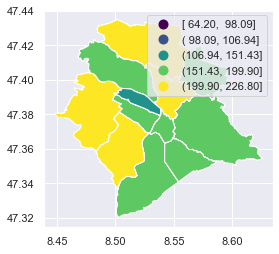

In [24]:
# Plot by StatZonen

stadtkreise_shapes_aktJahr.plot(column='AufDauerMedian', cmap='viridis', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html



Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=464&Source=http%3A%2F%2Fkollaboration%2Eintranet%2Estzh%2Ech%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs%2FPersonalViews%2Easpx%3FPageView%3DPersonal%26ShowWebPart%3D%7B6087A3E7%2D8AC8%2D40BA%2D8278%2DDECFACE124FF%7D%23InplviewHash6087a3e7%2D8ac8%2D40ba%2D8278%2Ddecface124ff%3DSortField%253DPackagename%2DSortDir%253DAsc%2DFilterField1%253DDiffusionsereignis%2DFilterValue1%253DBev%2525C3%2525B6lkerung%2525202020)**